# Local Spatial Autocorrelation Analysis



In [4]:
%matplotlib inline
import pysal as ps
import pandas as pd
import numpy as np
from pysal.contrib.viz import mapping as maps

First, let's read in some data:

In [7]:
data = ps.pdio.read_files("data/texas.shp")

In [8]:
data.head()

,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,STFIPS,COFIPS,FIPSNO,SOUTH,HR60,...,BLK90,GI59,GI69,GI79,GI89,FH60,FH70,FH80,FH90,geometry
0,Lipscomb,Texas,48,295,48295,48,295,48295,1,0.0,...,0.031817,0.286929,0.378219,0.407005,0.373005,6.724512,4.5,3.835360,6.093580,<pysal.cg.shapes.Polygon object at 0x1068ad850>
1,Sherman,Texas,48,421,48421,48,421,48421,1,0.0,...,0.139958,0.288976,0.359377,0.415453,0.378041,5.665722,1.7,3.253796,3.869407,<pysal.cg.shapes.Polygon object at 0x1068ad950>
2,Dallam,Texas,48,111,48111,48,111,48111,1,0.0,...,2.050906,0.331667,0.385996,0.370037,0.376015,7.546049,7.2,9.471366,14.231738,<pysal.cg.shapes.Polygon object at 0x1068ad490>
3,Hansford,Texas,48,195,48195,48,195,48195,1,0.0,...,0.000000,0.253527,0.357813,0.393938,0.383924,7.591786,4.7,5.542986,7.125457,<pysal.cg.shapes.Polygon object at 0x10f9be110>
4,Ochiltree,Texas,48,357,48357,48,357,48357,1,0.0,...,0.021911,0.236998,0.352940,0.343949,0.374461,5.172414,4.0,4.758392,9.159159,<pysal.cg.shapes.Polygon object at 0x10f9be510>


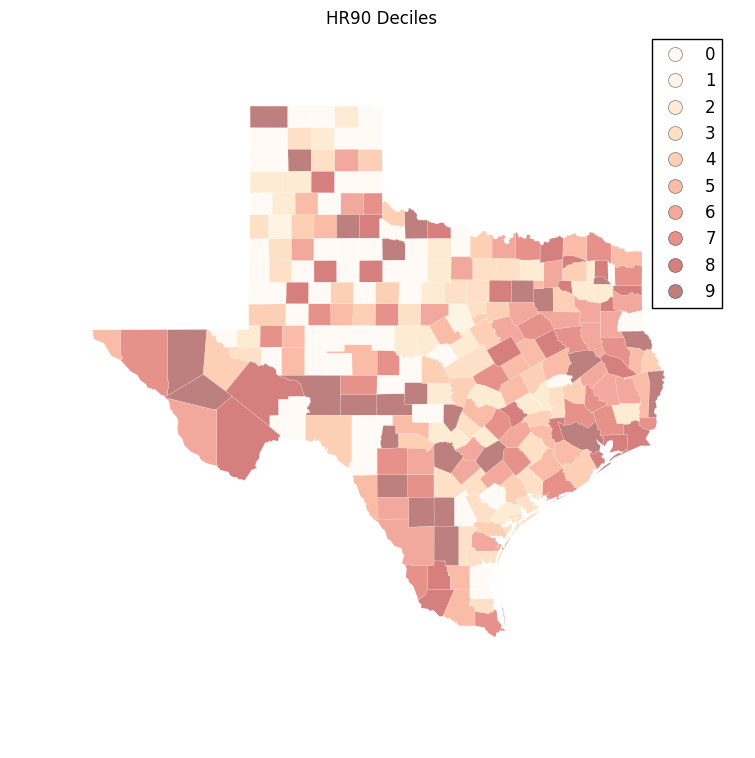

In [10]:
import matplotlib.pyplot as plt

import geopandas as gpd
shp_link = "data/texas.shp"
tx = gpd.read_file(shp_link)
hr10 = ps.Quantiles(data.HR90, k=10)
f, ax = plt.subplots(1, figsize=(9, 9))
tx.assign(cl=hr10.yb).plot(column='cl', categorical=True, \
        k=10, cmap='OrRd', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("HR90 Deciles")
plt.show()

In [13]:

data = ps.pdio.read_files("data/texas.shp")
W = ps.queen_from_shapefile("data/texas.shp")
W.transform = 'r'

In [14]:
HR90Lag = ps.lag_spatial(W, data.HR90)

In [15]:
HR90LagQ10 = ps.Quantiles(HR90Lag, k=10)

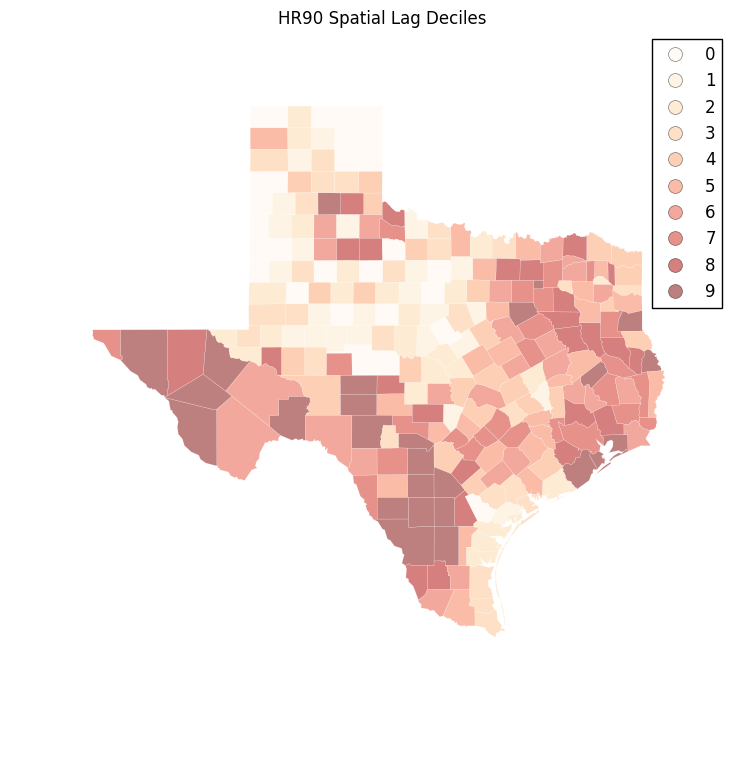

In [16]:
f, ax = plt.subplots(1, figsize=(9, 9))
tx.assign(cl=HR90LagQ10.yb).plot(column='cl', categorical=True, \
        k=10, cmap='OrRd', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("HR90 Spatial Lag Deciles")

plt.show()

The decile map for the spatial lag tends to enhance the impression of value similarity in space. However, we still have the challenge of visually associating the value of the homicide rate in a county with the value of the spatial lag of rates for the county. The latter is a weighted average of homicide rates in the focal county's neighborhood.

To complement the geovisualization of these associations we can turn to formal statistical measures of spatial autocorrelation.

In [17]:
HR90 = data.HR90
b,a = np.polyfit(HR90, HR90Lag, 1)

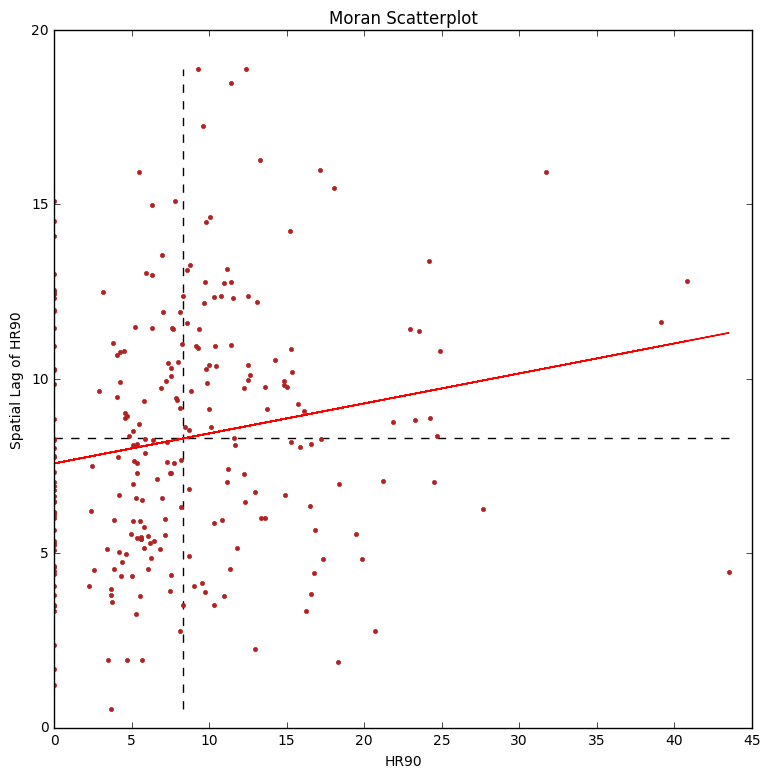

In [18]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(HR90, HR90Lag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(HR90.mean(), HR90Lag.min(), HR90Lag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(HR90Lag.mean(), HR90.min(), HR90.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(HR90, a + b*HR90, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of HR90')
plt.xlabel('HR90')
plt.show()

In [26]:
I_HR90 = ps.Moran(data.HR90.values, W)

## Local Autocorrelation Statistics

In addition to the Global autocorrelation statistics, PySAL has many local autocorrelation statistics. Let's compute a local Moran statistic for the same data shown above:

In [27]:
LMo_HR90 = ps.Moran_Local(data.HR90.values, W)

Now, instead of a single $I$ statistic, we have an *array* of local $I_i$ statistics, stored in the `.Is` attribute, and p-values from the simulation are in `p_sim`. 

In [28]:
LMo_HR90.Is[0:10], LMo_HR90.p_sim[0:10]

(array([ 1.12087323,  0.47485223, -1.22758423,  0.93868661,  0.68974296,
         0.78503173,  0.71047515,  0.41060686,  0.00740368,  0.14866352]),
 array([ 0.015,  0.17 ,  0.023,  0.009,  0.003,  0.005,  0.057,  0.05 ,
         0.476,  0.109]))

We can adjust the number of permutations used to derive every *pseudo*-$p$ value by passing a different `permutations` argument:

In [29]:
LMo_HR90 = ps.Moran_Local(data.HR90.values, W, permutations=9999)

In addition to the typical clustermap, a helpful visualization for LISA statistics is a Moran scatterplot with statistically significant LISA values highlighted. 

This is very simple, if we use the same strategy we used before:

First, construct the spatial lag of the covariate:

In [30]:
Lag_HR90 = ps.lag_spatial(W, data.HR90.values)
HR90 = data.HR90.values

Then, we want to plot the statistically-significant LISA values in a different color than the others. To do this, first find all of the statistically significant LISAs. Since the $p$-values are in the same order as the $I_i$ statistics, we can do this in the following way

In [31]:
sigs = HR90[LMo_HR90.p_sim <= .001]
W_sigs = Lag_HR90[LMo_HR90.p_sim <= .001]
insigs = HR90[LMo_HR90.p_sim > .001]
W_insigs = Lag_HR90[LMo_HR90.p_sim > .001]

Then, since we have a lot of points, we can plot the points with a statistically insignficant LISA value lighter using the `alpha` keyword. In addition, we would like to plot the statistically significant points in a dark red color. 

In [32]:
b,a = np.polyfit(HR90, Lag_HR90, 1)

Matplotlib has a list of [named colors](http://matplotlib.org/examples/color/named_colors.html) and will interpret colors that are provided in hexadecimal strings:

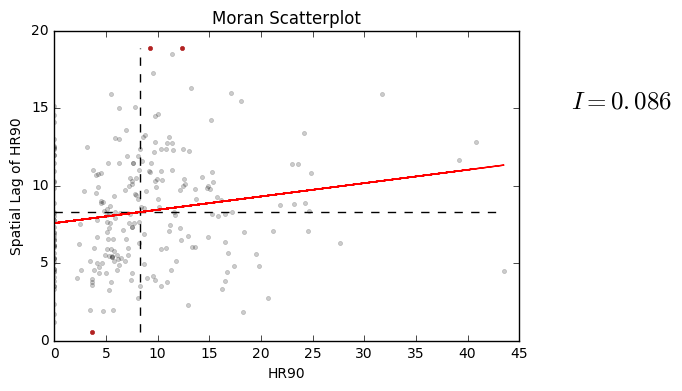

In [33]:
plt.plot(sigs, W_sigs, '.', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
 # dashed vert at mean of the last year's PCI
plt.vlines(HR90.mean(), Lag_HR90.min(), Lag_HR90.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(Lag_HR90.mean(), HR90.min(), HR90.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(HR90, a + b*HR90, 'r')
plt.text(s='$I = %.3f$' % I_HR90.I, x=50, y=15, fontsize=18)
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of HR90')
plt.xlabel('HR90')

We can also make a LISA map of the data. 

In [34]:
sig = LMo_HR90.p_sim < 0.05

In [35]:
sig.sum()

43

In [36]:
hotspots = LMo_HR90.q==1 * sig

In [37]:
hotspots.sum()

9

In [38]:
coldspots = LMo_HR90.q==3 * sig

In [39]:
coldspots.sum()

18

In [40]:
data.HR90[hotspots]

98      9.784698
132    11.435106
164    17.129154
209    13.274924
229    12.371338
234    31.721863
236     9.584971
239     9.256549
242    18.062652
Name: HR90, dtype: float64

In [41]:
data[hotspots]

,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,STFIPS,COFIPS,FIPSNO,SOUTH,HR60,...,BLK90,GI59,GI69,GI79,GI89,FH60,FH70,FH80,FH90,geometry
98,Ellis,Texas,48,139,48139,48,139,48139,1,9.217652,...,10.009746,0.325785,0.365177,0.352516,0.372783,12.418831,10.5,9.076165,12.031635,<pysal.cg.shapes.Polygon object at 0x11a97a2d0>
132,Hudspeth,Texas,48,229,48229,48,229,48229,1,9.971084,...,0.514580,0.312484,0.373474,0.440944,0.476631,14.115899,7.7,8.959538,11.363636,<pysal.cg.shapes.Polygon object at 0x10c7add10>
164,Jeff Davis,Texas,48,243,48243,48,243,48243,1,0.000000,...,0.359712,0.316019,0.367719,0.437014,0.399655,14.438503,10.1,5.970149,8.255159,<pysal.cg.shapes.Polygon object at 0x119d00850>
209,Chambers,Texas,48,071,48071,48,71,48071,1,3.211613,...,12.694146,0.299847,0.374105,0.378431,0.364723,9.462037,9.2,8.568120,10.598911,<pysal.cg.shapes.Polygon object at 0x1165de5d0>
229,Frio,Texas,48,163,48163,48,163,48163,1,3.296414,...,1.358373,0.390980,0.463020,0.435098,0.473507,14.665445,9.4,11.842919,18.330362,<pysal.cg.shapes.Polygon object at 0x11a473910>
234,La Salle,Texas,48,283,48283,48,283,48283,1,0.000000,...,1.008755,0.421556,0.482174,0.489173,0.492687,18.167702,14.1,13.052937,20.088626,<pysal.cg.shapes.Polygon object at 0x11a473d90>
236,Dimmit,Texas,48,127,48127,48,127,48127,1,0.000000,...,0.575098,0.417976,0.452789,0.456840,0.479503,13.826043,10.1,10.944363,17.769080,<pysal.cg.shapes.Polygon object at 0x11a4734d0>
239,Webb,Texas,48,479,48479,48,479,48479,1,2.057899,...,0.117083,0.382594,0.443082,0.439100,0.461075,20.292824,15.5,17.419676,20.521271,<pysal.cg.shapes.Polygon object at 0x11a4738d0>
242,Duval,Texas,48,131,48131,48,131,48131,1,2.487934,...,0.092894,0.370217,0.427660,0.421041,0.458937,15.829478,13.2,12.803677,20.699881,<pysal.cg.shapes.Polygon object at 0x119bd0910>


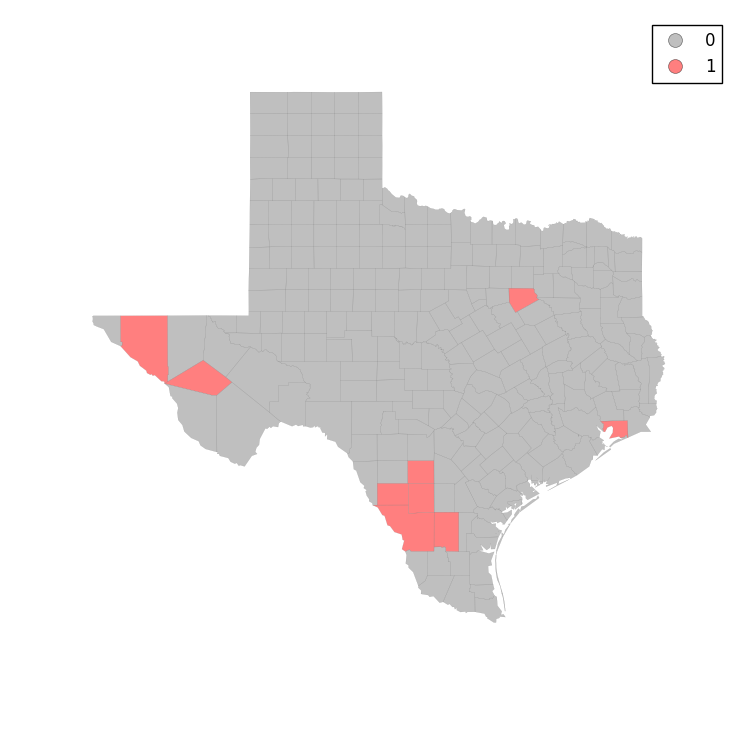

In [42]:
from matplotlib import colors
hmap = colors.ListedColormap(['grey', 'red'])
f, ax = plt.subplots(1, figsize=(9, 9))
tx.assign(cl=hotspots*1).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='grey', legend=True)
ax.set_axis_off()
plt.show()

In [43]:
data.HR90[coldspots]

0      0.000000
3      0.000000
4      3.651767
5      0.000000
13     5.669899
19     3.480743
21     3.675119
32     2.211607
33     4.718762
48     5.509870
51     0.000000
62     3.677958
68     5.043627
69     0.000000
81     0.000000
87     3.699593
140    8.125292
233    5.304688
Name: HR90, dtype: float64

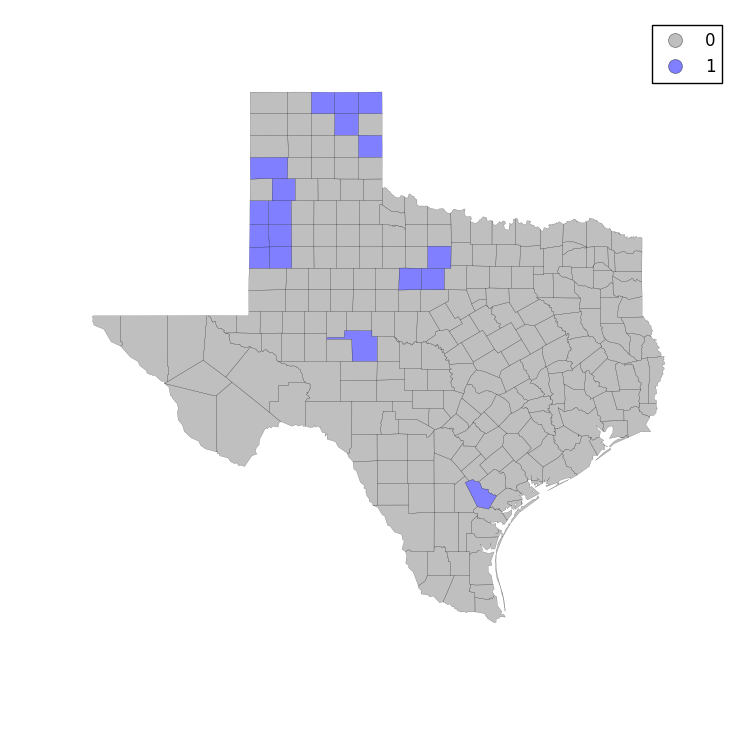

In [44]:
cmap = colors.ListedColormap(['grey', 'blue'])
f, ax = plt.subplots(1, figsize=(9, 9))
tx.assign(cl=coldspots*1).plot(column='cl', categorical=True, \
        k=2, cmap=cmap, linewidth=0.1, ax=ax, \
        edgecolor='black', legend=True)
ax.set_axis_off()
plt.show()


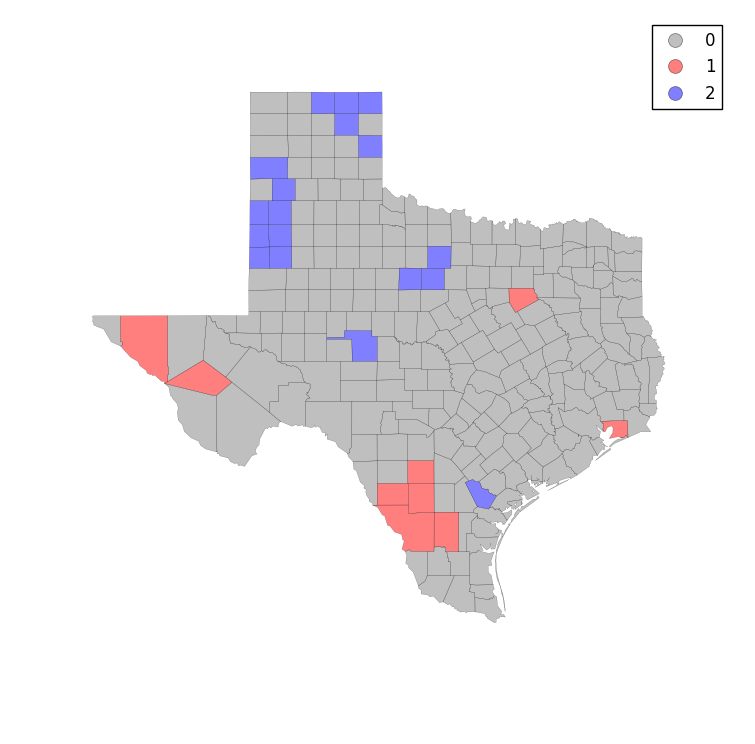

In [45]:
from matplotlib import colors
hcmap = colors.ListedColormap(['grey', 'red','blue'])
hotcold = hotspots*1 + coldspots*2
f, ax = plt.subplots(1, figsize=(9, 9))
tx.assign(cl=hotcold).plot(column='cl', categorical=True, \
        k=2, cmap=hcmap,linewidth=0.1, ax=ax, \
        edgecolor='black', legend=True)
ax.set_axis_off()
plt.show()

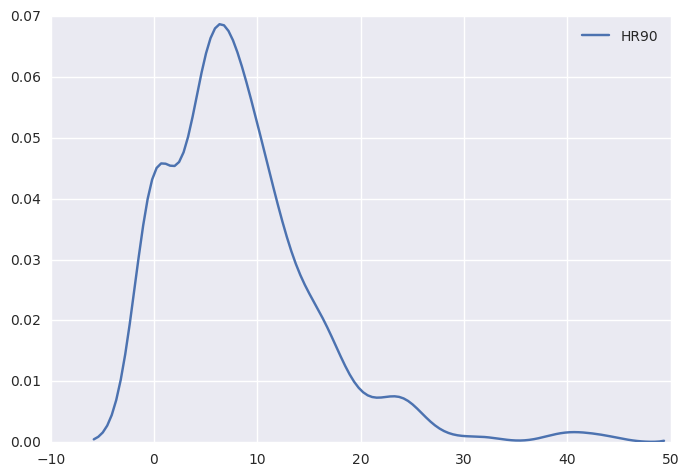

In [49]:
import seaborn as sns
sns.kdeplot(data.HR90)

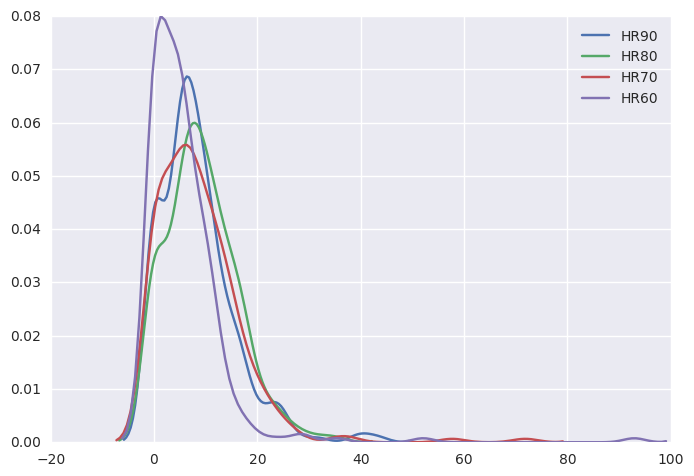

In [50]:
sns.kdeplot(data.HR90)
sns.kdeplot(data.HR80)
sns.kdeplot(data.HR70)
sns.kdeplot(data.HR60)

In [51]:
data.HR90.mean()

8.3024944602850379

In [52]:
data.HR90.median()

7.23234613355

## Exercises

1. Repeat the local analysis for the years 1960, 70, 80 and compare the results to what we found in 1990.
2. How many counties are hot spots in each of the periods?
3. The recent [Brexit vote](http://www.bbc.com/news/uk-politics-32810887) provides a timely example where local spatial autocorrelation analysis can provide interesting insights.  One [local analysis of the vote to leave](https://gist.github.com/darribas/691ad184280590d1219ffcf9a1678030) has recently been repored. Extend this to do an analysis of the attribute `Pct_remain`. Do the hot spots for the leave vote concord with the cold spots for the remain vote?

## Solutions

In [48]:
np.random.seed(12345)
I_pv = [ps.Moran(data[var].values, W).p_sim for var in ['HR60', 'HR70', 'HR80', 'HR90']]
I_pv

[0.121, 0.002, 0.001, 0.016]

In [51]:
LMs = [ps.Moran_Local(data[var].values, W) for var in ['HR60', 'HR70', 'HR80', 'HR90']]


In [55]:
#sig = LMo_HR90.p_sim < 0.05
#hotspots = LMo_HR90.q==1 * sig

hotspots = np.array([ (LM.p_sim < 0.05)*(LM.q==1) for LM in LMs]).T

In [57]:
hotspots.sum(axis=0)

array([ 6, 14, 22, 10])

In [59]:
hotspots.sum(axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 1,
       0, 2, 0, 1, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

In [60]:
hotspots.sum(axis=1).max()

2

In [72]:
data[hotspots.sum(axis=1)==2][['NAME','HR60','HR70', 'HR80','HR90']]

,NAME,HR60,HR70,HR80,HR90
90,Marion,16.565205,27.396188,35.392535,13.354701
93,Harrison,13.890717,16.354081,15.944386,8.698224
98,Ellis,9.217652,17.868119,12.274799,9.784698
108,Rusk,10.982675,16.616816,17.721070,9.145993
109,Panola,1.975894,23.069502,12.867529,0.000000
185,Montgomery,7.451842,10.778984,12.193192,11.525733
190,Liberty,12.660231,16.154763,22.652622,11.379585
